In [1]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
from sqlalchemy import create_engine
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
import time
import matplotlib.ticker as tkr
from scipy import stats
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
from sklearn.preprocessing import MinMaxScaler
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras import optimizers

%matplotlib inline

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [5]:
df1=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst =True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst =True)


df1 = df1.loc['2017-01-01':'2020-12-31']
df2 = df2.loc['2017-01-01':'2020-12-31']

index = pd.date_range(start='2017-01-01', end='2022-02-28', freq="1d")
columns = ["datetime_per_month", 'Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA','Electricity Consumption (MWh)']

df = pd.DataFrame(np.nan, index=range(0,index.size), columns=columns)
df["datetime_per_month"] = index
df.set_index("datetime_per_month", inplace=True)

df = df.resample("M").mean()


columns1 = ['Electricity Consumption (MWh)']
for column in columns1 : 
    df[column] = df2[column].resample("M").sum()
columns2=['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns2 : 
    df[column] = df2[column].resample("M").mean()
df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(13):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()

In [6]:
df = df.reset_index(level=0)

In [7]:
df["Date Time"] = pd.to_datetime(df['datetime_per_month'])

In [8]:
df["Day"] = df["Date Time"].dt.day
df["Month"] = df["Date Time"].dt.month
df["Year"] = df["Date Time"].dt.day
df["Hour"] = df["Date Time"].dt.hour
df["Minute"] = df["Date Time"].dt.minute
df["Demand"] = pd.to_numeric(df['Price - PT [€/MWh]'], errors = 'coerce')

In [9]:
columns = ['datetime_per_month','Date Time', 'Price - PT [€/MWh]', 'Price - ES [€/MWh]','Actual Consumption (MWh)', 'Biomass AA', 'Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)']
for column in columns :
  df.drop([column],  axis=1, inplace=True )

In [10]:
df

,Day,Month,Year,Hour,Minute,Demand
0,28,2,28,0,0,51.43
1,31,3,31,0,0,43.96
2,30,4,30,0,0,44.18
3,31,5,31,0,0,47.12
4,30,6,30,0,0,50.22
5,31,7,31,0,0,48.60
6,31,8,31,0,0,47.43
7,30,9,30,0,0,49.16
8,31,1,31,0,0,51.60
9,28,2,28,0,0,55.00


In [11]:
X= []
y= []

In [12]:
for i in range(0, df.shape[0]-4):
    X.append(df.iloc[i:i+4,5])
    y.append(df.iloc[i+4,5])
    
X, y = np.array(X), np.array(y)
y = np.reshape(y, (len(y), 1))

In [13]:
pd.DataFrame(X).to_csv('appended_Demand_m.csv')
pd.DataFrame(y).to_csv('appended_Demand_1_m.csv')

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [15]:
#split
size = int(len(df)*0.8)
           
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath ='models/MODEL.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',patience=50),
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

optimizers.Adam(lr=0.0001)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [18]:
start_time = time.time()

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=callbacks, batch_size=20)

exec_time = time.time()-start_time

Epoch 1/100
2/2 [==============================] - 9s 797ms/step - loss: 0.5353 - mae: 0.6827 - val_loss: 0.2754 - val_mae: 0.5182
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 0.4867 - mae: 0.6492 - val_loss: 0.2642 - val_mae: 0.5075
Epoch 3/100
2/2 [==============================] - 0s 53ms/step - loss: 0.4594 - mae: 0.6300 - val_loss: 0.2510 - val_mae: 0.4945
Epoch 4/100
2/2 [==============================] - 0s 53ms/step - loss: 0.4331 - mae: 0.6109 - val_loss: 0.2360 - val_mae: 0.4792
Epoch 5/100
2/2 [==============================] - 0s 57ms/step - loss: 0.4032 - mae: 0.5876 - val_loss: 0.2188 - val_mae: 0.4611
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 0.3687 - mae: 0.5607 - val_loss: 0.1997 - val_mae: 0.4402
Epoch 7/100
2/2 [==============================] - 0s 59ms/step - loss: 0.3270 - mae: 0.5278 - val_loss: 0.1782 - val_mae: 0.4154
Epoch 8/100
2/2 [==============================] - 0s 53ms/step - loss: 0.2855 - mae: 0.4

In [19]:
model.load_weights("models/MODEL.hdf5")

In [20]:
yhat = model.predict(X_test)

In [21]:
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y_test)

In [22]:
from sklearn import metrics
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 3.2334421049822217
Mean Squared Error: 12.850911052628533
Root Mean Squared Error: 3.584816739057735
Coefficient of Variance: 8.922049022726661
R2: -0.8285373912810006
exec_time: 12.910969257354736


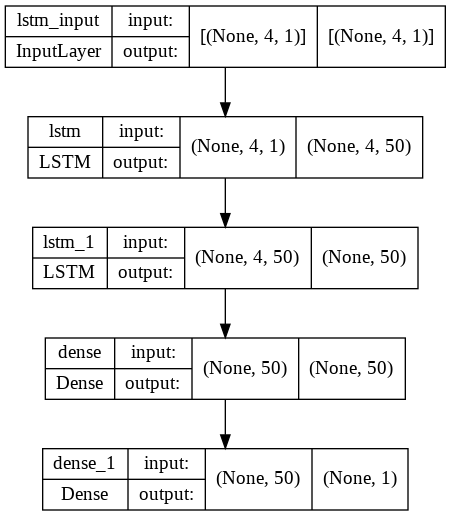

In [23]:
plot_model(model, show_shapes=True, show_layer_names=True )

In [24]:
import time

for i in range(0, X_test.shape[0]):
    demand_summary = []
    X_input = X_test[i,:,:]
    X_input = np.reshape(X_input, (1, X_input.shape[0], 1))
    X_input = model.predict(X_input)
    forecast = scaler.inverse_transform(X_input)
    
    
    y_input = y_test[i,:]
    y_input = np.reshape(y_input, (1,1))
    actual = scaler.inverse_transform(y_input)
    
    demand_summary.append(actual)
    demand_summary.extend(forecast)
    
    df_animate = pd.DataFrame(demand_summary)
    df_animate = df_animate.T
    df_animate.to_csv('real time demand.csv', mode='a', header=False, index=False)
    
    print(demand_summary)
    time.sleep(2)

[array([[36.4303629]]), array([35.224335], dtype=float32)]
[array([[42.08645833]]), array([37.124577], dtype=float32)]
[array([[42.02107527]]), array([38.488667], dtype=float32)]
